In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import torch
import torch.backends.cudnn as cudnn
import random
import numpy as np

# seeds
seed = 88
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
cudnn.deterministic = True
cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
from torchvision.datasets import FGVCAircraft
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# remove copyright banner
class RemoveCopyrightBanner(object):
    def __call__(self, img):
        width, height = img.size
        return img.crop((0, 0, width, height - 20))

transform = transforms.Compose([
    RemoveCopyrightBanner(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# granularity = 'variant'

# Create the FGVC Aircraft dataset instance
# train_dataset = FGVCAircraft(
#     root='./data',
#     split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
#     annotation_level=granularity,    # Options: 'variant', 'family', 'manufacturer'
#     transform=transform,
#     download=True
# )

# # shuffle the train dataset and split into 20% val, 80% train
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

# # val_dataset = FGVCAircraft(
# #     root='./data',
# #     split='val',
# #     annotation_level='variant',
# #     transform=transform,
# #     download=True
# # )

# test_dataset = FGVCAircraft(
#     root='./data',
#     split='test',
#     annotation_level=granularity,
#     transform=transform,
#     download=True
# )

100%|██████████| 2.75G/2.75G [01:54<00:00, 24.0MB/s]


## EDA on manufacturer annotation

In [15]:
# try loading manufacturer for annotation_level
from collections import defaultdict
from torch.utils.data import Subset

granularity = 'manufacturer'

def balance_train_val(trainval_dataset_full):
    TARGET_SAMPLES_PER_CLASS = 66

    print(f"Original trainval dataset size: {len(trainval_dataset_full)}")
    print(f"Number of manufacturers: {len(trainval_dataset_full.classes)}")

    # Group indices by manufacturer label
    print("\nGrouping indices by manufacturer...")
    manufacturer_indices = defaultdict(list)
    # Accessing internal attributes - use with understanding
    # _labels contains the integer index for the class of each sample
    for idx, label_index in enumerate(trainval_dataset_full._labels):
        manufacturer_indices[label_index].append(idx)

    # Print initial counts per class
    print("Original counts per manufacturer (showing first 10):")
    original_counts = {trainval_dataset_full.classes[lbl]: len(indices) for lbl, indices in manufacturer_indices.items()}
    for i, (manufacturer, count) in enumerate(original_counts.items()):
        if i < 10:
            print(f"- {manufacturer}: {count}")
        elif i == 10:
            print("...")
            break


    # Sample indices for each manufacturer
    print(f"\nSampling up to {TARGET_SAMPLES_PER_CLASS} indices per manufacturer...")
    balanced_indices = []
    total_sampled = 0
    for label_index, indices in manufacturer_indices.items():
        # Determine how many samples to take for this class
        num_samples = min(len(indices), TARGET_SAMPLES_PER_CLASS)
        # Randomly sample without replacement
        sampled_for_class = random.sample(indices, num_samples)
        balanced_indices.extend(sampled_for_class)
        total_sampled += num_samples

    print(f"Total indices sampled for balanced dataset: {len(balanced_indices)}")
    # Shuffle the final list of indices (optional but good practice)
    random.shuffle(balanced_indices)

    # Create a Subset using the balanced indices
    print("\nCreating balanced Subset...")
    balanced_trainval_dataset = Subset(trainval_dataset_full, balanced_indices)
    print(f"Balanced trainval dataset size: {len(balanced_trainval_dataset)}")

    train_dataset_manu, val_dataset_manu = torch.utils.data.random_split(balanced_trainval_dataset, [0.8, 0.2])
    return train_dataset_manu, val_dataset_manu


# trainval then split
trainval_dataset_manu = FGVCAircraft(
    root='./data',
    split='trainval',              # Options: 'train', 'val', 'trainval', 'test'
    annotation_level='manufacturer',    # Options: 'variant', 'family', 'manufacturer'
    transform=transform,
    download=True
)

train_dataset_manu, val_dataset_manu = balance_train_val(trainval_dataset_manu)
# original way without balancing
# train_dataset_manu, val_dataset_manu = torch.utils.data.random_split(trainval_dataset_manu, [0.8, 0.2])

test_dataset_manu = FGVCAircraft(
    root='./data',
    split='test',
    annotation_level='manufacturer',
    transform=transform,
    download=True
)

Original trainval dataset size: 6667
Number of manufacturers: 30

Grouping indices by manufacturer...
Original counts per manufacturer (showing first 10):
- Boeing: 1466
- Airbus: 867
- ATR: 133
- Antonov: 67
- British Aerospace: 267
- Beechcraft: 134
- Lockheed Corporation: 134
- Douglas Aircraft Company: 267
- Canadair: 267
- Cessna: 266
...

Sampling up to 66 indices per manufacturer...
Total indices sampled for balanced dataset: 1980

Creating balanced Subset...
Balanced trainval dataset size: 1980


In [8]:
import pandas as pd

# --- Function to convert dataset to DataFrame ---
def dataset_to_dataframe_manu(dataset: FGVCAircraft) -> pd.DataFrame:
    """Converts an FGVCAircraft dataset object into a Pandas DataFrame."""
    image_files = dataset._image_files  # List of full image paths
    labels = dataset._labels          # List of numerical label indices
    class_names = dataset.classes     # List of manufacturer names
    # print(class_names)

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names
    })
    return df

def show_dataframe_info_manu(df):
    # --- Display basic info and head of the DataFrame ---
    # print("\nTrain DataFrame Info:")
    # df_train.info()
    print("\nDataFrame Head:")
    print(df.head())

    # --- Calculate and display the counts per manufacturer ---
    print("\nNumber of images per manufacturer in dataset:")
    manufacturer_counts_train = df['manufacturer_name'].value_counts()
    print(manufacturer_counts_train)

    # --- additional info ---
    print("\nNumber of manufacturer in dataset:")
    print(len(manufacturer_counts_train))
    print("\nNumber of data in dataset:")
    print(len(df))


# --- Function to convert Subset to DataFrame ---
def subset_to_dataframe(subset) -> pd.DataFrame:
    """Converts a torch.utils.data.Subset object (wrapping FGVCAircraft)
       into a Pandas DataFrame."""

    original_dataset = subset.dataset # Get the underlying FGVCAircraft dataset
    subset_indices = subset.indices   # Get the list of indices for this subset

    # Access data from the *original* dataset using the subset indices
    image_files = [original_dataset._image_files[i] for i in subset_indices]
    labels = [original_dataset._labels[i] for i in subset_indices]
    class_names = original_dataset.classes # Get class names from original dataset

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'original_index': subset_indices, # Optional: Keep track of original index
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names
    })
    return df

def nested_subset_to_dataframe(subset_final: Subset) -> pd.DataFrame:
    """
    Converts a nested Subset (Subset of a Subset wrapping a base dataset like FGVCAircraft)
    into a Pandas DataFrame.
    """

    # --- Input Validation ---
    if not isinstance(subset_final, Subset):
        raise TypeError(f"Input must be a torch.utils.data.Subset, got {type(subset_final)}")

    # --- Access the intermediate Subset ---
    subset_intermediate = subset_final.dataset
    if not isinstance(subset_intermediate, Subset):
         print(f"Input Subset's dataset is not a Subset (nesting expected), got {type(subset_intermediate)}, calling subset_to_dataframe")
         return subset_to_dataframe(subset_final)

    # --- Access the original base dataset ---
    original_dataset = subset_intermediate.dataset
    # Add a check to ensure we reached a dataset with the expected attributes
    if not (hasattr(original_dataset, '_image_files') and
            hasattr(original_dataset, '_labels') and
            hasattr(original_dataset, 'classes')):
        raise TypeError(f"Base dataset (type: {type(original_dataset)}) doesn't have expected attributes "
                        "(_image_files, _labels, classes). Did nesting go wrong?")

    # --- Get the index lists ---
    indices_final = subset_final.indices         # Indices relative to subset_intermediate
    indices_intermediate = subset_intermediate.indices # Indices relative to original_dataset

    # --- Map final indices to original indices ---
    original_indices = [indices_intermediate[i] for i in indices_final]

    # --- Access data from the *original* dataset using the resolved original indices ---
    image_files = [original_dataset._image_files[orig_idx] for orig_idx in original_indices]
    labels = [original_dataset._labels[orig_idx] for orig_idx in original_indices]
    class_names = original_dataset.classes # Get class names from original dataset

    # Map numerical labels to manufacturer names
    manufacturer_names = [class_names[label_idx] for label_idx in labels]

    df = pd.DataFrame({
        'original_index': original_indices, # Index relative to the very original FGVCAircraft dataset
        'image_path': image_files,
        'manufacturer_index': labels,
        'manufacturer_name': manufacturer_names,
        # Optional: keep track of the index within the final subset if needed
        # 'final_subset_local_index': indices_final
    })
    return df


In [9]:
# --- Convert the train dataset to a DataFrame ---
print("\nConverting train dataset to DataFrame...")
# df_train_manu = subset_to_dataframe(train_dataset_manu)
df_train_manu = nested_subset_to_dataframe(train_dataset_manu)
print("Train DataFrame created.")

show_dataframe_info_manu(df_train_manu)
# df_train_manu.head(800)


Converting train dataset to DataFrame...
Train DataFrame created.

DataFrame Head:
   original_index                                         image_path  \
0            1220  ./data/fgvc-aircraft-2013b/data/images/1376795...   
1            2811  ./data/fgvc-aircraft-2013b/data/images/0564173...   
2            3081  ./data/fgvc-aircraft-2013b/data/images/2203115...   
3            4924  ./data/fgvc-aircraft-2013b/data/images/1961974...   
4            5725  ./data/fgvc-aircraft-2013b/data/images/1269006...   

   manufacturer_index     manufacturer_name  
0                   2               Antonov  
1                  19  Lockheed Corporation  
2                   9       Cirrus Aircraft  
3                   8                Cessna  
4                  14           Eurofighter  

Number of images per manufacturer in dataset:
manufacturer_name
Saab                        60
Piper                       59
Embraer                     58
Cessna                      57
British Aerospace 

In [10]:
# --- Convert the val dataset to a DataFrame ---
print("\nConverting val dataset to DataFrame...")
df_val_manu = nested_subset_to_dataframe(val_dataset_manu)
print("Train DataFrame created.")

show_dataframe_info_manu(df_val_manu)


Converting val dataset to DataFrame...
Train DataFrame created.

DataFrame Head:
   original_index                                         image_path  \
0            5112  ./data/fgvc-aircraft-2013b/data/images/1543346...   
1            2783  ./data/fgvc-aircraft-2013b/data/images/0979868...   
2            5972  ./data/fgvc-aircraft-2013b/data/images/1950531...   
3            3210  ./data/fgvc-aircraft-2013b/data/images/1373008...   
4            3021  ./data/fgvc-aircraft-2013b/data/images/1472109...   

   manufacturer_index         manufacturer_name  
0                  12  Douglas Aircraft Company  
1                  18                  Ilyushin  
2                   5      Bombardier Aerospace  
3                  22                   Panavia  
4                   3                Beechcraft  

Number of images per manufacturer in dataset:
manufacturer_name
Douglas Aircraft Company    21
de Havilland                20
Robin                       20
Eurofighter                

In [11]:
# --- Convert the test dataset to a DataFrame ---
print("\nConverting test dataset to DataFrame...")
df_test_manu = dataset_to_dataframe_manu(test_dataset_manu)
print("Test DataFrame created.")

show_dataframe_info_manu(df_test_manu)


Converting test dataset to DataFrame...
Test DataFrame created.

DataFrame Head:
                                          image_path  manufacturer_index  \
0  ./data/fgvc-aircraft-2013b/data/images/1514522...                   4   
1  ./data/fgvc-aircraft-2013b/data/images/0747566...                   4   
2  ./data/fgvc-aircraft-2013b/data/images/1008575...                   4   
3  ./data/fgvc-aircraft-2013b/data/images/0717480...                   4   
4  ./data/fgvc-aircraft-2013b/data/images/0991569...                   4   

  manufacturer_name  
0            Boeing  
1            Boeing  
2            Boeing  
3            Boeing  
4            Boeing  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      734
Airbus                      433
McDonnell Douglas           233
Embraer                     233
de Havilland                166
Cessna                      134
Canadair                    133
Douglas Aircraft Company    133
British 

In [12]:
# --- Convert the original trainval dataset to a DataFrame ---
print("\nConverting trainval dataset to DataFrame...")
df_trainval_manu = dataset_to_dataframe_manu(trainval_dataset_manu)
print("Test DataFrame created.")

show_dataframe_info_manu(df_trainval_manu)


Converting trainval dataset to DataFrame...
Test DataFrame created.

DataFrame Head:
                                          image_path  manufacturer_index  \
0  ./data/fgvc-aircraft-2013b/data/images/1025794...                   4   
1  ./data/fgvc-aircraft-2013b/data/images/1340192...                   4   
2  ./data/fgvc-aircraft-2013b/data/images/0056978...                   4   
3  ./data/fgvc-aircraft-2013b/data/images/0698580...                   4   
4  ./data/fgvc-aircraft-2013b/data/images/0450014...                   4   

  manufacturer_name  
0            Boeing  
1            Boeing  
2            Boeing  
3            Boeing  
4            Boeing  

Number of images per manufacturer in dataset:
manufacturer_name
Boeing                      1466
Airbus                       867
McDonnell Douglas            467
Embraer                      467
de Havilland                 334
British Aerospace            267
Canadair                     267
Douglas Aircraft Company     

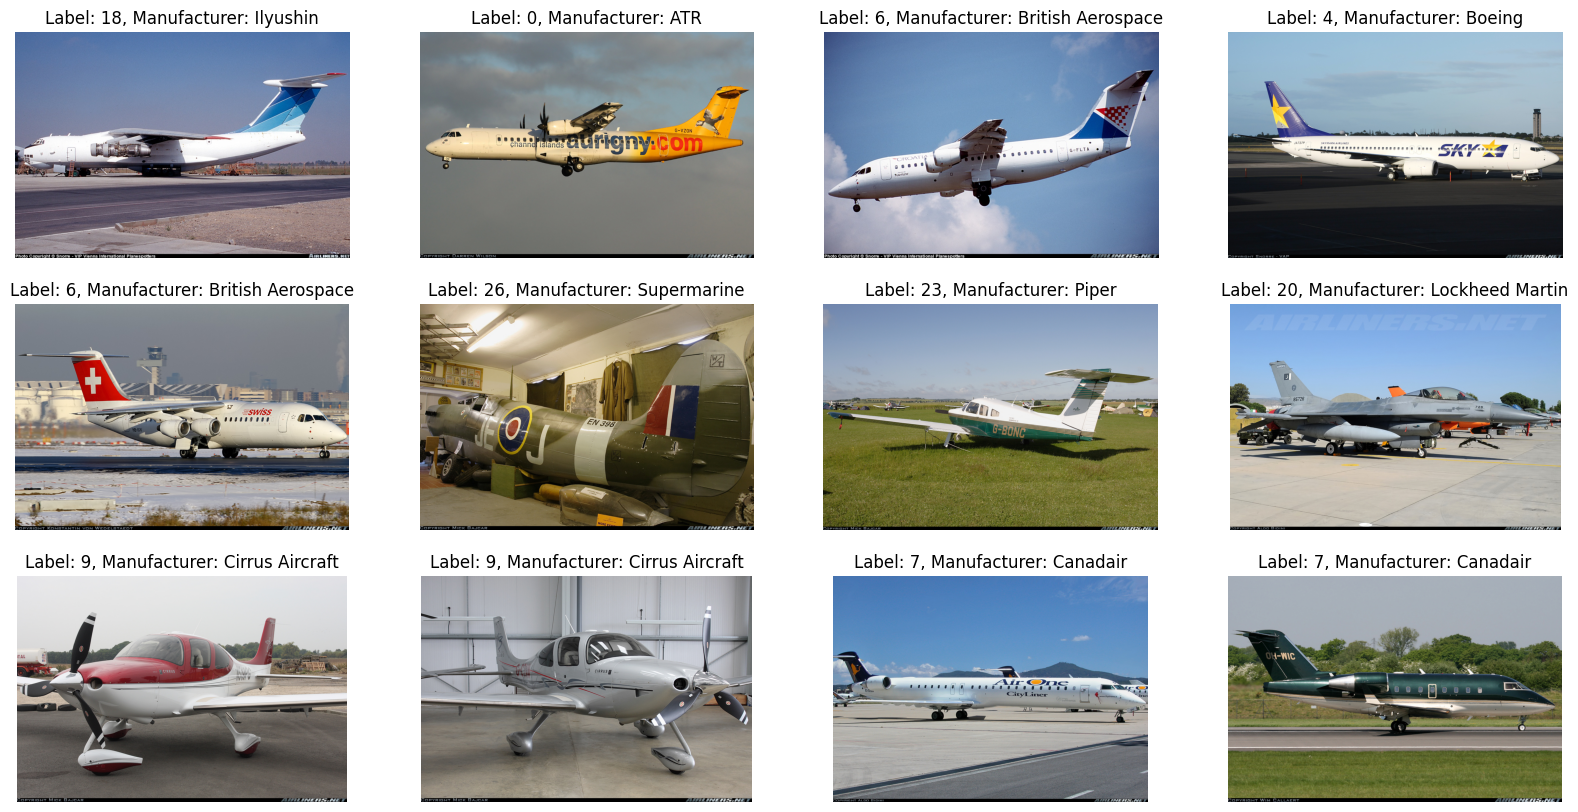

In [13]:
import random
from PIL import Image

# show various manufactuers
def show_images_manu(df, num_images_per_row=5, num_row=3):
    fig, axes = plt.subplots(num_row, num_images_per_row, figsize=(20, 10))
    for i in range(num_images_per_row * num_row):
        index_to_show = random.randint(0, len(df_train_manu) - 1)

        # Get the row corresponding to the chosen index
        image_row = df_train_manu.iloc[index_to_show]
        image_path = image_row['image_path']
        manufacturer_name = image_row['manufacturer_name']
        label = image_row['manufacturer_index']

        img = Image.open(image_path)

        r = i // num_images_per_row
        c = i% num_images_per_row

        # image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[r, c].imshow(img)
        axes[r, c].set_title(f'Label: {label}, Manufacturer: {manufacturer_name}')
        axes[r, c].axis('off')
    plt.show()

show_images_manu(df_train_manu, num_images_per_row=4)

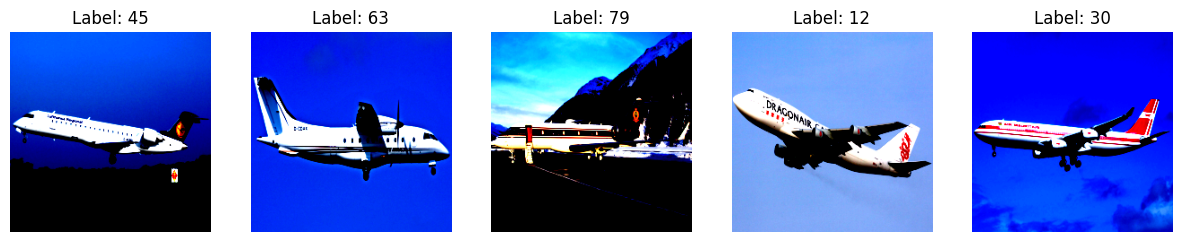

In [14]:
# function to show images
def show_images(train_dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, label = train_dataset[i]
        image = image.permute(1, 2, 0)  # convert from CxHxW to HxWxC
        axes[i].imshow(image)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

show_images(train_dataset, num_images=5)

# Create Dataset

In [16]:
from collections import defaultdict
import torch
from tqdm import tqdm

def group_task_indices(dataset, cumulative=False, max_per_class=1000):
    """
    Task 0: 0-9, Task 1: 10-19, ..., Task 9: 90-99
    Output a dictionary where keys are task indices and values are lists of image indices.
    For example, task_dict[0] will contain indices of images with labels 0-9.
    """
    per_class_counts = defaultdict(int)
    task_dict = defaultdict(list)
    for idx, (_, label) in tqdm(enumerate(dataset), total=len(dataset)):
        # for test and val, should have cumulative indices (all classes seen so far)
        if per_class_counts[label] >= max_per_class:
          continue
        per_class_counts[label] += 1
        if cumulative:
          for i in range((label // 10), 3):
            task_dict[i].append(idx)
        else:
          task_dict[label // 10].append(idx)
    return task_dict

train_task_idxs = group_task_indices(train_dataset_manu, cumulative=False)
val_task_idxs = group_task_indices(val_dataset_manu, cumulative=True)
test_task_idxs = group_task_indices(test_dataset_manu, cumulative=True)

100%|██████████| 3333/3333 [00:45<00:00, 73.90it/s]


In [ ]:
# labels_dict = defaultdict(int)
# for i in tqdm(train_task_idxs[1], total=len(train_task_idxs)):
#     _, label = train_dataset[i]
#     labels_dict[label] += 1
# print(labels_dict)

522it [00:06, 83.79it/s]

defaultdict(<class 'int'>, {17: 54, 19: 53, 15: 53, 13: 49, 14: 51, 11: 52, 10: 52, 18: 53, 16: 54, 12: 51})


## Training Code

In [17]:
def val_net(net_to_val, val_loader):
    net_to_val.eval()
    loss = 0

    criterion = torch.nn.CrossEntropyLoss()

    with torch.no_grad():
        for img, label in tqdm(val_loader, desc="Validating"):

            # Get the input images and their corresponding labels
            img, label = img.cuda(), label.cuda()

            # Forward pass: Get predictions from the model
            outputs = net_to_val(img)

            # compute SmoothL1Losss
            loss += criterion(outputs, label)

        return loss / len(val_loader)

def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    # prepare the net for training
    net_to_train.cuda()

    # freeze backbone
    for param in net_to_train.parameters():
        param.requires_grad = False
    for param in net_to_train.fc.parameters():
        param.requires_grad = True

    # loop over the dataset multiple times
    for epoch in range(max_epochs):
        net_to_train.train()

        running_loss = 0.0

        # unfreeze all layers
        if epoch == freeze_epochs:
          for param in net_to_train.parameters():
              param.requires_grad = True
              # change optimizer learning rate
              opt.param_groups[0]['lr'] = 1e-4

        # train on batches of data
        for imgs, labels in tqdm(train_loader, unit='batch'):

            imgs, labels = imgs.cuda(), labels.cuda()

            # zero the parameter gradients
            opt.zero_grad()

            # prediction
            outputs = net_to_train(imgs)

            # compute the loss
            loss = criterion(outputs, labels)
            loss.backward()
            opt.step()

            # print loss statistics
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        val_losses.append(val_net(net_to_train, val_loader))
        print(f"Epoch {epoch + 1}, Training Loss: {avg_loss:.3f}, Validation Loss: {val_losses[-1]:.3f}")

        # save to checkpoint
        if save_path:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net_to_train.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': avg_loss,
            }, save_path)
            print(f"Checkpoint saved to {save_path}")

        # save task, trainloss, valloss to file
        if save_file:
            with open(save_file, 'a') as f:
                f.write(f"{task},{epoch + 1},{avg_loss},{val_losses[-1]}\n")

        # early stopping based on patience
        if len(val_losses) > patience and val_losses[-1] >= min(val_losses[:-patience]):
            print(f"Early stopping at epoch {epoch + 1}")
            break

    print("finished training")
    return train_losses, val_losses

In [18]:
import torch.nn as nn
def modify_resnet_head(model, num_classes):
  """
  Modify the last fully connected layer of the ResNet model to match the number of classes.
  """

  old_fc = model.fc
  old_num_classes = old_fc.out_features
  num_ftrs = old_fc.in_features

  # Create the new head
  new_fc = nn.Linear(num_ftrs, num_classes).cuda()

  # Copy weights and biases from the old head
  if old_num_classes < num_classes:
    new_fc.weight.data[:old_num_classes, :] = old_fc.weight.data.clone().cuda()
    new_fc.bias.data[:old_num_classes] = old_fc.bias.data.clone().cuda()

  model.fc = new_fc
  return model

In [19]:
import torch

def get_test_accuracy(model, test_loader, num_classes):
    model.eval()
    correct_preds = 0
    total = 0
    correct_per_class = [0] * num_classes
    total_per_class = [0] * num_classes

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Testing", total=len(test_loader)):
            imgs, labels = imgs.cuda(), labels.cuda()
            output = model(imgs)
            preds = output.argmax(dim=1)

            correct_preds += (preds == labels).sum().item()
            total += labels.size(0)

            # Per-class stats
            for c in range(num_classes):
                correct_per_class[c] += ((preds == c) & (labels == c)).sum().item()
                total_per_class[c] += (labels == c).sum().item()

    overall_acc = correct_preds / total
    per_class_acc = [correct_per_class[c] / total_per_class[c] if total_per_class[c] > 0 else 0.0
                     for c in range(num_classes)]
    return overall_acc, per_class_acc


In [ ]:
from torch.utils.data import Subset
from torchvision import models
import torch.optim as optim

# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=32, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
# )

# create output file for train and val losses

save_dir = 'naive'

for task in range(10):

    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=0.0015)

    train_loader = torch.utils.data.DataLoader(
        Subset(train_dataset, train_task_idxs[task]), batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=g
    )
    val_loader = torch.utils.data.DataLoader(
        Subset(val_dataset, val_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    test_loader = torch.utils.data.DataLoader(
        Subset(test_dataset, test_task_idxs[task]), batch_size=64, shuffle=False, num_workers=4, worker_init_fn=seed_worker, generator=g
    )

    # create output file for train and val losses
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Train the model on the current task
    train_losses, val_losses = train_net(15, 5, 8, model, optimizer, train_loader, val_loader, task, save_file=os.path.join(save_dir, 'train_val_losses.txt'))

    # Evaluate the model on the test set
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader, (task+1) * 10)
    print(f"Overall accuracy for task {task}: {overall_acc:.4f}")
    print(f"Per-class accuracy for task {task}: {per_class_acc}")

    # save to text file in save dir
    if not os.path.exists(os.path.join(save_dir, 'accuracies.txt')):
        with open(os.path.join(save_dir, 'accuracies.txt'), 'w') as f:
            f.write("Task,Overall Accuracy,Per-Class Accuracy\n")
    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    # Save the model after training on each task in save dir
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

Training on task 0...


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]


Epoch 1, Training Loss: 2.352, Validation Loss: 2.339


Validating: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


Epoch 2, Training Loss: 2.117, Validation Loss: 2.136


 89%|████████▉ | 8/9 [00:06<00:00,  1.25batch/s]


KeyboardInterrupt: 

In [ ]:
# zip the naive folder
import shutil
shutil.make_archive('naive', 'zip', 'naive')

'/content/naive.zip'

## Replay Code

In [20]:
def train_net(max_epochs, freeze_epochs, patience, net_to_train, opt, train_loader, val_loader, task, save_file=None, save_path=None):
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    net_to_train.cuda()

    initial_freeze = (task == 0) # Only freeze initially for the very first task

    for name, param in net_to_train.named_parameters():
        # do not train non-fc layers
        if initial_freeze and 'fc' not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    optimizer = opt

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"Starting training for Task {task}. Trainable parameters:")
    for name, param in net_to_train.named_parameters():
        if param.requires_grad:
             print(f"  - {name}")


    for epoch in range(max_epochs):
        net_to_train.train()
        running_loss = 0.0

        # Unfreeze logic (if desired for staged training within a task)
        if epoch == freeze_epochs and task > 0: # Only unfreeze/adjust LR if NOT task 0 and freeze_epochs > 0
            print(f"Unfreezing backbone at epoch {epoch} for task {task}")
            for param in net_to_train.parameters():
                param.requires_grad = True
            # Adjust LR for the existing optimizer
            current_lr = optimizer.param_groups[0]['lr']
            new_lr = 1e-4 # Or some other value
            if current_lr != new_lr:
                 print(f"Setting LR to {new_lr}")
                 for g in optimizer.param_groups:
                     g['lr'] = new_lr


        for imgs, labels in tqdm(train_loader, unit='batch', desc=f"Task {task} Epoch {epoch+1}"):
            imgs, labels = imgs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net_to_train(imgs)
            loss = criterion(outputs, labels) # Loss calculated on combined batch
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # --- Validation (Use Cumulative Loader!) ---
        current_val_loss = val_net(net_to_train, val_loader) # val_loader MUST be cumulative
        val_losses.append(current_val_loss)

        print(f"Task {task}, Epoch {epoch + 1}, Train Loss: {avg_loss:.4f}, Val Loss (Cumulative): {current_val_loss:.4f}")

        # --- Logging to file ---
        if save_file:
             with open(save_file, 'a') as f:
                  f.write(f"{task},{epoch + 1},{avg_loss},{current_val_loss}\n") # Log cumulative val loss

        # --- Early Stopping (Based on CUMULATIVE validation loss) ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epochs_no_improve = 0
            if save_path: # Optional: save best model state
               torch.save(net_to_train.state_dict(), os.path.join(save_path, f"model_task{task}_best.pth"))
               print(f"  New best validation loss: {best_val_loss:.4f}. Saved best model.")
        else:
            epochs_no_improve += 1
            # print(f"  Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}") # Optional verbose print

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1} for task {task}. Best Val Loss: {best_val_loss:.4f}")
            if save_path and os.path.exists(os.path.join(save_path, f"model_task{task}_best.pth")):
               print("Loading best model weights before exiting.")
               net_to_train.load_state_dict(torch.load(os.path.join(save_path, f"model_task{task}_best.pth")))
            break

    print(f"Finished training task {task}")
    return train_losses, val_losses

In [21]:
import random
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import models
import torch.optim as optim


# Initialize the model
model = models.resnet18(pretrained=True)

# freeze all parameters except the last fc layer
for name, param in model.named_parameters():
    if name != 'fc.weight' and name != 'fc.bias':
        param.requires_grad = False

# --- Add outside the loop ---
memory_buffer = [] # Simple list to store (image_tensor, label) tuples
memory_size = 1000 # Max number of samples in buffer (hyperparameter)
samples_per_task_in_memory = 20 # How many samples to add from each task (hyperparameter)

def update_memory_buffer(buffer, max_size, new_samples):
    """Adds new samples to the buffer and trims it if it exceeds max_size."""
    buffer.extend(new_samples)
    # If buffer exceeds max size, remove samples randomly (or use FIFO)
    overflow = len(buffer) - max_size
    if overflow > 0:
        # Randomly remove 'overflow' samples
        indices_to_remove = random.sample(range(len(buffer)), overflow)
        # Remove in reverse sorted order to avoid index shifting issues
        for index in sorted(indices_to_remove, reverse=True):
            del buffer[index]
        # Alternatively, for FIFO: del buffer[:overflow]
    print(f"Memory buffer size: {len(buffer)} / {max_size}")

class MemoryDataset(Dataset):
    """A simple Dataset wrapper for the list-based memory buffer."""
    def __init__(self, buffer_list):
        self.buffer = buffer_list

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        # buffer contains (image_tensor, label)
        return self.buffer[idx]

# --- Modify your main loop ---
save_dir = 'replay-manu' # Changed directory name

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# Clear or initialize log files
open(os.path.join(save_dir, 'train_val_losses.txt'), 'w').close()
open(os.path.join(save_dir, 'accuracies.txt'), 'w').write("Task,Overall Accuracy,Per-Class Accuracy\n")


for task in range(3):
    print(f"Training on task {task}...")

    model = modify_resnet_head(model, (task+1) * 10)
    model = model.cuda()

    # --- Prepare Current Task Dataset ---
    current_task_train_subset = Subset(train_dataset_manu, train_task_idxs[task])

    # --- Prepare Combined Training Loader ---
    if task > 0 and len(memory_buffer) > 0:
        # Create a dataset from the memory buffer
        replay_dataset = MemoryDataset(memory_buffer)
        # Combine current task data and replay data
        combined_train_dataset = ConcatDataset([current_task_train_subset, replay_dataset])
        print(f"Task {task}: Training with {len(current_task_train_subset)} current samples and {len(replay_dataset)} manu samples.")
    else:
        # Task 0 or empty buffer: train only on current task data
        combined_train_dataset = current_task_train_subset
        print(f"Task {task}: Training only with {len(current_task_train_subset)} current samples.")

    # Create DataLoader for the combined dataset
    # Adjust batch size if needed, maybe smaller if memory is large
    train_loader_combined = DataLoader(
        combined_train_dataset,
        batch_size=128, # Or adjust dynamically
        shuffle=True,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Validation and Test Loaders (Should still be CUMULATIVE!) ---
    val_loader_cumulative = torch.utils.data.DataLoader(
        Subset(val_dataset_manu, val_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    test_loader_cumulative = torch.utils.data.DataLoader(
        Subset(test_dataset_manu, test_task_idxs[task]),
        batch_size=256,
        shuffle=False,
        num_workers=4,
        worker_init_fn=seed_worker,
        generator=g
    )

    # --- Optimizer ---
    # Consider re-initializing or adjusting LR, especially after task 0
    if task == 0:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0015)
    else:
        optimizer = optim.Adam(model.parameters(), lr=1e-4) # Lower LR for full network


    # --- Train the model ---
    # train_net now uses the combined loader
    # No need for EWC parameters here
    train_losses, val_losses = train_net(
        max_epochs=15,
        freeze_epochs=5, # Still relevant if you want staged training
        patience=5,
        net_to_train=model,
        opt=optimizer,
        train_loader=train_loader_combined, # Use the combined loader
        val_loader=val_loader_cumulative, # Use the CUMULATIVE validation loader
        task=task,
        save_file=os.path.join(save_dir, 'train_val_losses.txt')
    )

    # --- Update Memory Buffer AFTER training ---
    # Select samples from the task just finished
    num_to_sample = min(samples_per_task_in_memory, len(current_task_train_subset))
    if num_to_sample > 0:
        indices_to_sample = random.sample(range(len(current_task_train_subset)), num_to_sample)
        new_memory_samples = []
        print(f"Sampling {num_to_sample} examples from task {task} for memory buffer...")
        for idx in indices_to_sample:
            # Get the actual data point (image tensor, label) from the subset
            img_tensor, label = current_task_train_subset[idx]
            new_memory_samples.append((img_tensor, label)) # Append as tuple

        # Add to buffer and manage size
        update_memory_buffer(memory_buffer, memory_size, new_memory_samples)
    else:
        print(f"Not enough samples in task {task} subset to add to memory.")


    # --- Evaluate and Save ---
    overall_acc, per_class_acc = get_test_accuracy(model, test_loader_cumulative, (task+1) * 10)
    print(f"Overall accuracy for task {task} (on classes 0-{(task+1)*10 - 1}): {overall_acc:.4f}")

    with open(os.path.join(save_dir, 'accuracies.txt'), 'a') as f:
        f.write(f"{task},{overall_acc:.4f},{per_class_acc}\n")

    torch.save(model.state_dict(), os.path.join(save_dir, f"model_task_{task}.pth"))
    print(f"Model for task {task} saved as model_task_{task}.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


Training on task 0...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Task 0: Training only with 516 current samples.
Starting training for Task 0. Trainable parameters:
  - fc.weight
  - fc.bias


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


Task 0, Epoch 1, Train Loss: 2.3685, Val Loss (Cumulative): 2.2648


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Task 0, Epoch 2, Train Loss: 2.2047, Val Loss (Cumulative): 2.1189


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Task 0, Epoch 3, Train Loss: 2.0148, Val Loss (Cumulative): 2.1683


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


Task 0, Epoch 4, Train Loss: 1.8198, Val Loss (Cumulative): 2.0736


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


Task 0, Epoch 5, Train Loss: 1.7750, Val Loss (Cumulative): 2.0805


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.14s/it]


Task 0, Epoch 6, Train Loss: 1.6692, Val Loss (Cumulative): 1.9617


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.02s/it]


Task 0, Epoch 7, Train Loss: 1.7975, Val Loss (Cumulative): 1.8723


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


Task 0, Epoch 8, Train Loss: 1.5270, Val Loss (Cumulative): 1.8095


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]


Task 0, Epoch 9, Train Loss: 1.5758, Val Loss (Cumulative): 1.8297


Validating: 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Task 0, Epoch 10, Train Loss: 1.5641, Val Loss (Cumulative): 1.7931


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


Task 0, Epoch 11, Train Loss: 1.4972, Val Loss (Cumulative): 1.7295


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Task 0, Epoch 12, Train Loss: 1.3601, Val Loss (Cumulative): 1.6828


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


Task 0, Epoch 13, Train Loss: 1.4152, Val Loss (Cumulative): 1.6778


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Task 0, Epoch 14, Train Loss: 1.1573, Val Loss (Cumulative): 1.7800


Validating: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


Task 0, Epoch 15, Train Loss: 1.2820, Val Loss (Cumulative): 1.7275
Finished training task 0
Sampling 20 examples from task 0 for memory buffer...
Memory buffer size: 20 / 1000


Testing: 100%|██████████| 8/8 [00:21<00:00,  2.70s/it]


Overall accuracy for task 0 (on classes 0-9): 0.4800
Model for task 0 saved as model_task_0.pth
Training on task 1...
Task 1: Training with 533 current samples and 20 manu samples.
Starting training for Task 1. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.weight

Validating: 100%|██████████| 2/2 [00:04<00:00,  2.00s/it]


Task 1, Epoch 1, Train Loss: 2.3873, Val Loss (Cumulative): 2.9845


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.92s/it]


Task 1, Epoch 2, Train Loss: 1.2618, Val Loss (Cumulative): 2.9271


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Task 1, Epoch 3, Train Loss: 0.7214, Val Loss (Cumulative): 2.8340


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


Task 1, Epoch 4, Train Loss: 0.3940, Val Loss (Cumulative): 2.8594


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


Task 1, Epoch 5, Train Loss: 0.2354, Val Loss (Cumulative): 2.9342
Unfreezing backbone at epoch 5 for task 1


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Task 1, Epoch 6, Train Loss: 0.1374, Val Loss (Cumulative): 3.0005


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


Task 1, Epoch 7, Train Loss: 0.0861, Val Loss (Cumulative): 3.0395


Validating: 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


Task 1, Epoch 8, Train Loss: 0.0595, Val Loss (Cumulative): 3.0595
Early stopping triggered at epoch 8 for task 1. Best Val Loss: 2.8340
Finished training task 1
Sampling 20 examples from task 1 for memory buffer...
Memory buffer size: 40 / 1000


Testing: 100%|██████████| 11/11 [00:32<00:00,  2.92s/it]


Overall accuracy for task 1 (on classes 0-19): 0.2438
Model for task 1 saved as model_task_1.pth
Training on task 2...
Task 2: Training with 535 current samples and 40 manu samples.
Starting training for Task 2. Trainable parameters:
  - conv1.weight
  - bn1.weight
  - bn1.bias
  - layer1.0.conv1.weight
  - layer1.0.bn1.weight
  - layer1.0.bn1.bias
  - layer1.0.conv2.weight
  - layer1.0.bn2.weight
  - layer1.0.bn2.bias
  - layer1.1.conv1.weight
  - layer1.1.bn1.weight
  - layer1.1.bn1.bias
  - layer1.1.conv2.weight
  - layer1.1.bn2.weight
  - layer1.1.bn2.bias
  - layer2.0.conv1.weight
  - layer2.0.bn1.weight
  - layer2.0.bn1.bias
  - layer2.0.conv2.weight
  - layer2.0.bn2.weight
  - layer2.0.bn2.bias
  - layer2.0.downsample.0.weight
  - layer2.0.downsample.1.weight
  - layer2.0.downsample.1.bias
  - layer2.1.conv1.weight
  - layer2.1.bn1.weight
  - layer2.1.bn1.bias
  - layer2.1.conv2.weight
  - layer2.1.bn2.weight
  - layer2.1.bn2.bias
  - layer3.0.conv1.weight
  - layer3.0.bn1.weigh

Validating: 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]


Task 2, Epoch 1, Train Loss: 2.8686, Val Loss (Cumulative): 3.1277


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.97s/it]


Task 2, Epoch 2, Train Loss: 1.5216, Val Loss (Cumulative): 3.0707


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]


Task 2, Epoch 3, Train Loss: 0.8112, Val Loss (Cumulative): 3.1124


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.03s/it]


Task 2, Epoch 4, Train Loss: 0.4560, Val Loss (Cumulative): 3.2172


Validating: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


Task 2, Epoch 5, Train Loss: 0.2473, Val Loss (Cumulative): 3.2442
Unfreezing backbone at epoch 5 for task 2


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.89s/it]


Task 2, Epoch 6, Train Loss: 0.1431, Val Loss (Cumulative): 3.2361


Validating: 100%|██████████| 2/2 [00:05<00:00,  2.76s/it]


Task 2, Epoch 7, Train Loss: 0.0880, Val Loss (Cumulative): 3.2327
Early stopping triggered at epoch 7 for task 2. Best Val Loss: 3.0707
Finished training task 2
Sampling 20 examples from task 2 for memory buffer...
Memory buffer size: 60 / 1000


Testing: 100%|██████████| 14/14 [00:41<00:00,  2.98s/it]

Overall accuracy for task 2 (on classes 0-29): 0.1851
Model for task 2 saved as model_task_2.pth


In [22]:
import shutil
shutil.make_archive('replay-manu', 'zip', 'replay-manu')

'/content/replay-manu.zip'

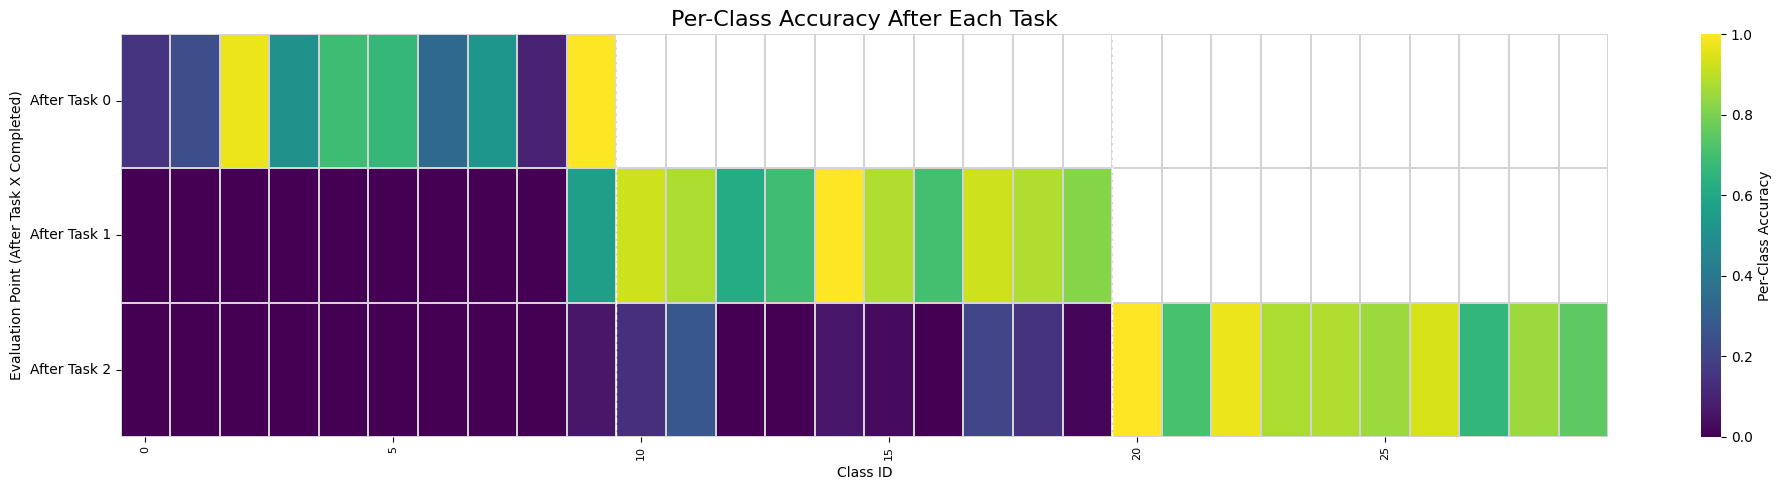

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import ast # To safely evaluate the string list literal
import os # To check if file exists

# --- Configuration ---
accuracy_file_path = 'replay-manu/accuracies.txt' # Make sure this file exists
num_total_classes = 30 # FGVC Aircraft manufacturer has 30 classes
num_classes_per_task = 10

# --- Data Loading and Manual Parsing ---
parsed_data = {}

# Check if the file exists before trying to read
if not os.path.exists(accuracy_file_path):
    print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
    print("Please make sure you have saved the data into a file named 'accuracies.txt' in the correct directory.")
    exit()

try:
    with open(accuracy_file_path, 'r') as f:
        header = f.readline().strip() # Read and ignore the header line
        if not header.startswith("Task,Overall Accuracy,Per-Class Accuracy"):
             print("Warning: Header doesn't exactly match expected format, but proceeding.")

        for line_num, line in enumerate(f, start=2): # Start line count from 2 for error messages
            line = line.strip()
            if not line: # Skip empty lines
                continue

            try:
                # Find the first comma to isolate Task ID
                first_comma_idx = line.find(',')
                if first_comma_idx == -1:
                    raise ValueError("Missing first comma separating Task ID")
                task_id_str = line[:first_comma_idx]
                task_id = int(task_id_str)

                # Find the second comma to isolate Overall Accuracy (and the start of the list)
                # Start searching *after* the first comma
                second_comma_idx = line.find(',', first_comma_idx + 1)
                if second_comma_idx == -1:
                     raise ValueError("Missing second comma separating Overall Accuracy")

                # The rest of the line, starting after the second comma, is the list string
                list_str = line[second_comma_idx + 1:]

                # Safely evaluate the string list using ast.literal_eval
                per_class_acc_list = ast.literal_eval(list_str)

                # Validate that it's actually a list
                if not isinstance(per_class_acc_list, list):
                    raise TypeError(f"Parsed data for 'Per-Class Accuracy' is not a list (type: {type(per_class_acc_list)}).")

                # Convert elements to float just in case
                per_class_acc_list = [float(acc) for acc in per_class_acc_list]
                parsed_data[task_id] = per_class_acc_list
                # print(f"Parsed Task {task_id}, found {len(per_class_acc_list)} accuracies.") # Optional print

            except (ValueError, SyntaxError, TypeError, IndexError) as e:
                print(f"Warning: Could not parse line {line_num}. Error: {e}. Line content: '{line}'")
            except Exception as e:
                # Catch any other unexpected errors during parsing of a specific line
                print(f"An unexpected error occurred parsing line {line_num}: {e}")


except FileNotFoundError:
    # This case is handled by the os.path.exists check above, but kept for safety
    print(f"Error: Accuracy file not found at '{accuracy_file_path}'")
    exit()
except Exception as e:
    # Catch errors related to opening or reading the file itself
    print(f"Error reading file '{accuracy_file_path}': {e}")
    exit()

# --- Prepare Data Matrix for Heatmap (Code remains the same) ---
num_tasks_found = len(parsed_data)
if num_tasks_found == 0:
    print("No valid task data parsed. Exiting.")
    exit()

# Create a matrix: rows = tasks, cols = classes
# Initialize with NaN for classes not yet seen/evaluated
acc_matrix = np.full((num_tasks_found, num_total_classes), np.nan)

sorted_task_ids = sorted(parsed_data.keys())

for task_idx, task_id in enumerate(sorted_task_ids):
    accuracies = parsed_data[task_id]
    num_classes_in_task_eval = len(accuracies)
    if num_classes_in_task_eval > num_total_classes:
         print(f"Warning: Task {task_id} reported {num_classes_in_task_eval} accuracies, exceeding total classes {num_total_classes}. Truncating.")
         num_classes_in_task_eval = num_total_classes
         accuracies = accuracies[:num_total_classes]

    # Fill the matrix row for this task up to the number of classes evaluated
    acc_matrix[task_idx, :num_classes_in_task_eval] = accuracies

# --- Plotting the Heatmap (Code remains the same) ---
plt.figure(figsize=(20, max(5, num_tasks_found * 0.7))) # Adjusted size

heatmap = sns.heatmap(
    acc_matrix,
    annot=False,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.2,
    linecolor='lightgrey',
    cbar_kws={'label': 'Per-Class Accuracy'},
    vmin=0.0,
    vmax=1.0
)

plt.xlabel("Class ID")
plt.ylabel("Evaluation Point (After Task X Completed)")
plt.title("Per-Class Accuracy After Each Task", fontsize=16)
plt.xticks(ticks=np.arange(0, num_total_classes, 5) + 0.5, labels=np.arange(0, num_total_classes, 5), rotation=90, fontsize=8)
plt.yticks(ticks=np.arange(num_tasks_found) + 0.5, labels=[f"After Task {t}" for t in sorted_task_ids], rotation=0)

for i in range(num_classes_per_task, num_total_classes, num_classes_per_task):
    plt.axvline(x=i, color='white', linestyle='--', linewidth=1.0)

plt.tight_layout()
plt.show()